In [93]:
import torch
# import torch.nn as neuralnet
import torch.optim as optim
import torchsde
import numpy as np
import math
import matplotlib.pyplot as plt
from src.create_lattice import build_lattice_grid, clean_deribit, read_parquet, apply_lattice
from src.noarb_lattice import build_noarb_constraints, projection_fast_cvxpy
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from src.decomp_lattice import compute_surface_curl
from sklearn.decomposition import PCA

## Reading in and building lattice from train set

In [94]:
file_path = "/Users/arjunshah/Documents/UTS/Thesis/neural-sdes/data/deribit_options_2025-01-30_100k_rows.parquet"
df = read_parquet(file_path)
df = clean_deribit(df = df)
df = df.sort_values("timestamp")
all_times = df['timestamp'].unique()
i_ts = int(len(all_times) * 0.8)
train_times = all_times[:i_ts]
test_times = all_times[i_ts:]
train_df = df[df['timestamp'].isin(train_times)].copy()
test_df  = df[df['timestamp'].isin(test_times)].copy()
nn, full_nodes, full_tau_grid, full_m_grid = build_lattice_grid(train_df)

# on train only
Ci_train, nodes_sub, τ_sub, m_sub = apply_lattice(
  train_df, nn, full_nodes, full_tau_grid, full_m_grid
)
A, b = build_noarb_constraints(nodes_sub, τ_sub, m_sub)

C_arb_train = projection_fast_cvxpy(Ci_train, nodes_sub, τ_sub, m_sub)


/Users/arjunshah/Documents/UTS/Thesis/deribit-deep-learning/src/create_lattice.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['expiry'] = pd.to_datetime(df['expiry'])
/Users/arjunshah/Documents/UTS/Thesis/deribit-deep-learning/src/create_lattice.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mid_price'] = (df['best_bid_price'] + df['best_ask_price']) / 2
/Users/arjunshah/Documents/UTS/Thesis/deribit-deep-learning/src/create_lattice.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

## Building lattice for test set
using train set, so there is no data leakage

In [95]:
# 1) Apply the SAME grid & no‐arb constraints to the test data:
Ci_test, _, _, _ = apply_lattice(
    test_df, nn, full_nodes, full_tau_grid, full_m_grid
)
C_arb_test = projection_fast_cvxpy(
    Ci_test, nodes_sub, τ_sub, m_sub
)

# Renaming for clarity
# Csurf_train = Ci_train.copy()
# Csurf_test  = Ci_test.copy()

Csurf_train = C_arb_train.copy()
Csurf_test  = C_arb_test.copy()


## Extracting spot

In [96]:
train_times_sorted = np.sort(train_times)
test_times_sorted  = np.sort(test_times)

#    aligned to those same timestamps:
#    assume df has column 'underlying_price'
spot_train = (
    train_df
    .drop_duplicates('timestamp')
    .set_index('timestamp')
    .loc[train_times_sorted, 'underlying_price']
    .values
)   # shape (T_train,)
spot_test  = (
    test_df
    .drop_duplicates('timestamp')
    .set_index('timestamp')
    .loc[test_times_sorted,  'underlying_price']
    .values
)   # shape (T_test,)

## Extract delta-t arrays

In [97]:
# convert timestamps to pandas datetime:
tt_train = pd.to_datetime(train_times_sorted, unit='ms')
tt_test  = pd.to_datetime(test_times_sorted,  unit='ms')
sec_per_year = 365*24*3600

dt_train = (tt_train[1:] - tt_train[:-1]).total_seconds() / sec_per_year
dt_test  = (tt_test[1:]  - tt_test[:-1]).total_seconds()  / sec_per_year


## Computing Surface Derivatives

using np.gradient

In [98]:
from scipy.interpolate import SmoothBivariateSpline

def fit_and_evaluate_smooth_spline(Csurf, nodes, kx=1, ky=2, s=0):
    """
    Fit a C^{1,2} spline to each surface Csurf[t] on irregular nodes,
    then evaluate its first ∂/∂tau, first ∂/∂moneyness, and second ∂²/∂moneyness²
    at the original nodes.

    Parameters
    ----------
    Csurf : ndarray, shape (T, N)
        Call-price surfaces flattened over N irregular nodes.
    nodes : ndarray, shape (N, 2)
        Array of [tau_j, m_j] locations for each of the N nodes.
    kx : int, default=1
        Degree of spline in tau direction (C^1 continuity).
    ky : int, default=2
        Degree of spline in moneyness direction (C^2 continuity).
    s : float, default=0
        Smoothing factor; s=0 forces interpolation.

    Returns
    -------
    dC_dtau   : ndarray, shape (T, N)
    dC_dm      : ndarray, shape (T, N)
    d2C_dm2    : ndarray, shape (T, N)
    """
    taus = nodes[:, 0]
    ms   = nodes[:, 1]
    T, N = Csurf.shape

    dC_dtau = np.zeros((T, N))
    dC_dm   = np.zeros((T, N))
    d2C_dm2 = np.zeros((T, N))

    Csurf_arr = Csurf.values

    for t in range(T):
        values = Csurf_arr[t]  # (N,)
        spline = SmoothBivariateSpline(taus, ms, values, kx=kx, ky=ky, s=s)

        # evaluate derivatives at each node
        dC_dtau[t, :] = spline.ev(taus, ms, dx=1, dy=0)
        dC_dm[t, :]   = spline.ev(taus, ms, dx=0, dy=1)
        d2C_dm2[t, :] = spline.ev(taus, ms, dx=0, dy=2)

    return dC_dtau, dC_dm, d2C_dm2


#### Test

In [99]:
dCtau_train, dCm_train, d2Cm2_train = fit_and_evaluate_smooth_spline(
    Csurf_train, nodes_sub, kx=2, ky=3, s=1e-8
)


### Some visualisations of the derivatives of the call price surface from the train data

In [100]:
taus = nodes_sub[:, 0]
ms   = nodes_sub[:, 1]
T, N = Csurf_train.shape

dC_dtau = np.zeros((T, N))
dC_dm   = np.zeros((T, N))
d2C_dm2 = np.zeros((T, N))
Csurf_arr = Csurf_train.values

for t in range(T):
    values = Csurf_arr[t, :]   # (N,)
    spline = SmoothBivariateSpline(taus, ms, values, kx=2, ky=3, s=1e-6)

    # evaluate derivatives at each node
    dC_dtau[t, :] = spline.ev(taus, ms, dx=1, dy=0)
    dC_dm[t, :]   = spline.ev(taus, ms, dx=0, dy=1)
    d2C_dm2[t, :] = spline.ev(taus, ms, dx=0, dy=2)

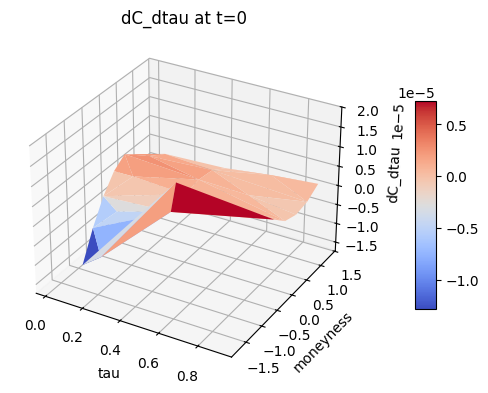

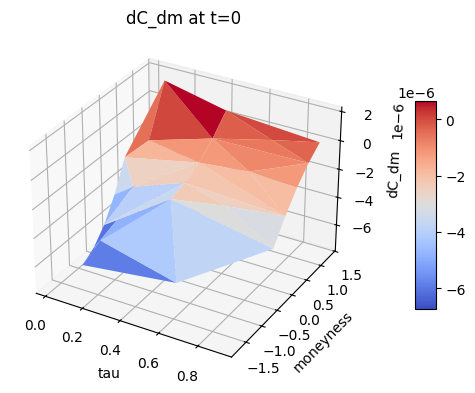

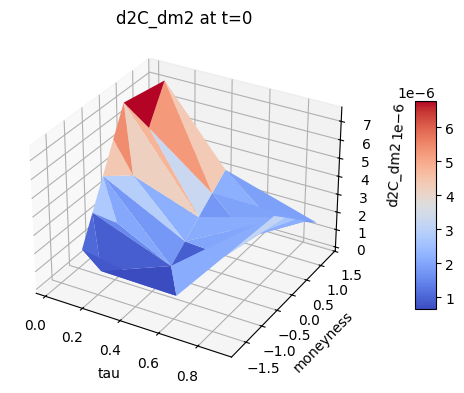

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

# t0 = which snapshot you want to plot, e.g. 0
t0 = 0

# nodes_sub (N,2), dC_dtau, dC_dm, d2C_dm2 all shape (T,N)
taus = nodes_sub[:, 0]
ms   = nodes_sub[:, 1]
triang = tri.Triangulation(taus, ms)

# grab the three fields at time t0
Z1 = dC_dtau[t0]   # ∂C/∂τ
Z2 = dC_dm[t0]     # ∂C/∂m
Z3 = d2C_dm2[t0]   # ∂²C/∂m²

for Z, name in zip((Z1, Z2, Z3),
                   ('dC_dtau', 'dC_dm', 'd2C_dm2')):
    fig = plt.figure(figsize=(6,4))
    ax  = fig.add_subplot(111, projection='3d')

    surf = ax.plot_trisurf(
        triang, Z,
        cmap='coolwarm',      # reds=high, blues=low
        linewidth=0.1,        # mesh lines
        antialiased=True
    )

    ax.set_xlabel('tau')
    ax.set_ylabel('moneyness')
    ax.set_zlabel(name)
    ax.set_title(f'{name} at t={t0}')

    fig.colorbar(surf, shrink=0.6, aspect=10, pad=0.1)
    plt.tight_layout()

plt.show()


#### Animated gif of dc/dtau on train

In [102]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.tri as tri
# from matplotlib.animation import FuncAnimation, PillowWriter

# # Assume dC_dtau and nodes_sub are already in memory
# # Focus on ∂C/∂tau animation

# taus = nodes_sub[:, 0]
# ms = nodes_sub[:, 1]
# T, N = dC_dtau.shape

# triang = tri.Triangulation(taus, ms)

# zmin = float(np.min(dC_dtau))
# zmax = float(np.max(dC_dtau))

# fig = plt.figure(figsize=(6, 4))
# ax = fig.add_subplot(projection='3d')

# def update(frame_idx):
#     ax.clear()
#     surf = ax.plot_trisurf(
#         triang,
#         dC_dtau[frame_idx],
#         cmap='coolwarm',
#         antialiased=True,
#         linewidth=0.2,
#         vmin=zmin,
#         vmax=zmax
#     )
#     ax.set_zlim(zmin, zmax)
#     ax.set_xlabel('tau')
#     ax.set_ylabel('moneyness')
#     ax.set_zlabel('∂C/∂tau')
#     ax.set_title(f'∂C/∂tau at t={frame_idx}')
#     return surf,

# step = max(T // 100, 1)
# frame_indices = np.arange(0, T, step)

# anim = FuncAnimation(fig, update, frames=frame_indices, blit=False)

# gif_path = 'data/dC_dtau_evolution.gif'
# anim.save(gif_path, writer=PillowWriter(fps=10))

# print("Animation saved to:", gif_path)


### Test 

In [103]:
dCtau_test, dCm_test, d2Cm2_test = fit_and_evaluate_smooth_spline(
    Csurf_test, nodes_sub, kx=2, ky=3, s=1e-8
)


## Now working out the 'gamma' the variance of the underlying process
we have to fit an initial SDE to get this

In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class Stage0Net(nn.Module):
    """
    Simple neural network to model dS = f(X)*dt + g(X)*dW for the underlying S only.
    """
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.drift = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        self.diffusion = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
            nn.Softplus()  # ensures positivity
        )

    def forward(self, x):
        f = self.drift(x)
        g = self.diffusion(x)
        return f, g


def train_stage0(net, X_S, dS, dt, epochs=200, lr=1e-3, batch_size=256):
    """
    Train the Stage-0 SDE on S only so that net.diffusion(X) ≈ instantaneous vol γ_t.

    Parameters
    ----------
    net : Stage0Net instance
    X_S : np.ndarray, shape (L, input_dim)
        Training features (e.g., [S_t, PCA_scores])
    dS  : np.ndarray, shape (L,)
        Observed increments S_{t+1} - S_t
    dt  : np.ndarray, shape (L,)
        Time-step sizes
    epochs : int
        Number of training epochs
    lr : float
        Learning rate
    batch_size : int
        Batch size for DataLoader

    Returns
    -------
    gamma_series : np.ndarray, shape (L,)
        Estimated instantaneous volatility at each training step.
    """
    # Convert to torch tensors
    X_tensor  = torch.from_numpy(X_S).float()
    dS_tensor = torch.from_numpy(dS).float().unsqueeze(1)
    dt_tensor = torch.from_numpy(dt).float().unsqueeze(1)

    dataset = TensorDataset(X_tensor, dS_tensor, dt_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = optim.Adam(net.parameters(), lr=lr)

    for _ in range(epochs):
        for xb, yb, dtb in loader:
            f_pred, g_pred = net(xb)
            # Negative log-likelihood for Euler-Maruyama
            var = g_pred**2 * dtb + 1e-8
            loss = ((yb - f_pred * dtb)**2 / (2 * var) + 0.5 * torch.log(var)).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # After training, compute gamma_t = g_pred (instantaneous vol) on all X_S
    with torch.no_grad():
        _, g_all = net(X_tensor)
    gamma_series = g_all.squeeze().cpu().numpy()
    return gamma_series



### Now we run PCA on entire options surface (train) and fit the neural SDE

In [105]:
from sklearn.decomposition import PCA

# Number of components to keep
d0 = 15 # keep high for tiny reconstruction error

pca0 = PCA(n_components = d0).fit(Csurf_train)

pcs_train = pca0.transform(Csurf_train)[:, :d0]

# Sport train
ds = spot_train[1:] - spot_train[:-1]

X0 = np.hstack([
    spot_train[:-1, None],
    pcs_train[:-1]
])

# Instantiate model
input_dim = X0.shape[1]    # = 1 + d0
net0 = Stage0Net(input_dim=input_dim, hidden_dim=32)

# train and get gamma_series (instantaneous volatility) on train
gamma_train = train_stage0(
    net0,
    X0,                # (L, input_dim)
    ds,          # (L,)
    dt_train.to_numpy(),          # (L,)
    epochs=200,
    lr=1e-3,
    batch_size=256
)

with torch.no_grad():
    _, gS_train = net0(torch.from_numpy(X0).float())
gamma_train = gS_train.squeeze().cpu().numpy()          # absolute (for dS)
sigma_train = gamma_train / spot_train[:-1]              # γ_t used in Z

### Now using it to get the gamma values from the test set
ensuring no data leakage

In [106]:
pcs_test = pca0.transform(Csurf_test)[:, :d0]
X0_test = np.hstack([spot_test[:-1, None], pcs_test[:-1]])
with torch.no_grad():
    _, gS_test = net0(torch.from_numpy(X0_test).float())
gamma_test = gS_test.cpu().numpy().squeeze()

sigma_test = gS_test.squeeze().cpu().numpy() / spot_test[:-1]

##### Lets look at this train fitted vol
this is the initial gamma parameter, the vol of the underlying via a neural sde.

some methods in the literature use this model to then price options by simulating the underlying and discounting back to prices visible in the market. Calibration vs Estimation

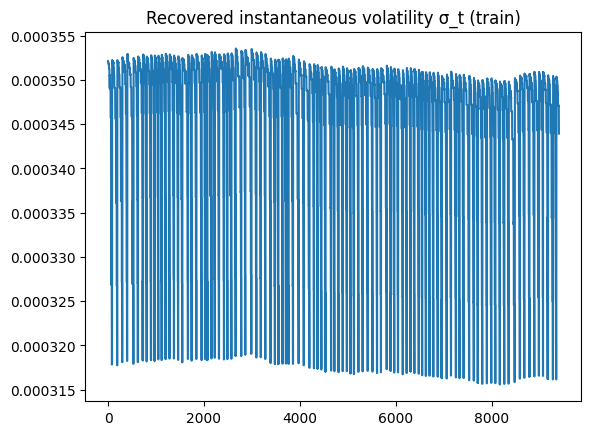

In [107]:
S_train = spot_train[:-1]                 # same index as gamma_train
sigma_train = gamma_train / S_train 

import matplotlib.pyplot as plt
plt.plot(sigma_train)
plt.title("Recovered instantaneous volatility σ_t (train)")
plt.show()

##### Test fitted vol

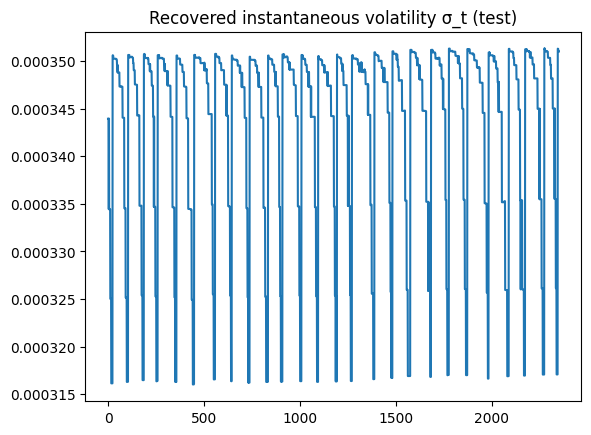

In [108]:
import matplotlib.pyplot as plt
plt.plot(sigma_test)
plt.title("Recovered instantaneous volatility σ_t (test)")
plt.show()

### Now building the z_t. This is the dynamic arbitrage factor

In [109]:
def build_z(dCtau, dCm, d2Cm2, sigma):
    # dCtau, dCm, d2Cm2: arrays of shape (T, N)
    # sigma: length-(T-1) array
    T, N = dCtau.shape
    # we’ll build z for t=0…T-2
    Z = np.zeros((T-1, N))
    for t in range(T-1):
        s2 = sigma[t]**2
        Z[t] = (
            -dCtau[t]
            - 0.5 * s2 * dCm[t]
            + 0.5 * s2 * d2Cm2[t]
        )
    return Z



#### Train

In [110]:
# we drop the last row of the derivative arrays so they match length
Z_train = build_z(
    dCtau_train[:-1], 
    dCm_train[:-1], 
    d2Cm2_train[:-1], 
    sigma_train
)

#### Test

In [111]:
Z_test = build_z(
    dCtau_test[:-1],
    dCm_test[:-1],
    d2Cm2_test[:-1],
    sigma_test
)

## Creating the decomposed market model lattice

### Train

In [112]:
import numpy as np
from sklearn.decomposition import PCA

# ── STEP 1: Compute the price baseline G0 ──────────────────────────────────────
# Csurf_train: shape (T_train, N)
G0_price = Csurf_train.mean(axis=0)     # shape (N,)

# 1) Ensure Csurf_train is an ndarray
if hasattr(Csurf_train, "values"):
    Csurf_arr = Csurf_train.values
else:
    Csurf_arr = np.asarray(Csurf_train)

# 2) Ensure G0_price is an ndarray
G0_arr = np.asarray(G0_price)   # shape (24,)




# ── STEP 2: Form the price residual R0_prices ─────────────────────────────────
# R0_prices[t, j] = Csurf_train[t, j] – G0_price[j]

#  Now subtract with explicit new-axis
R0_prices = Csurf_arr - G0_arr[np.newaxis, :] 

# ── STEP 3: Extract dynamic‐arbitrage factors from Z_train ────────────────────
dda     = 3   # for example, number of dynamic‐arb factors
pca_dyn = PCA(n_components=dda).fit(Z_train)
G_dyn   = pca_dyn.components_                 # shape (dda, N)

# project the price residuals onto those directions:
Xi_dyn_train = R0_prices.dot(G_dyn.T)         # shape (T_train, dda)

# ── STEP 4: Peel off the dynamic‐arb contribution ────────────────────────────
# R_dda[t] = R0_prices[t] – sum_{k=1..dda} Xi_dyn[t,k] * G_dyn[k]
R_dda_train = R0_prices - Xi_dyn_train.dot(G_dyn)   # shape (T_train, N)

# ── STEP 5: Extract statistical‐accuracy factors from R_dda ──────────────────
dst      = 2  # number of statistical‐accuracy factors
pca_stat = PCA(n_components=dst).fit(R_dda_train)
G_stat   = pca_stat.components_               # shape (dst, N)

# project the leftover residuals:
Xi_stat_train = R_dda_train.dot(G_stat.T)     # shape (T_train, dst)

### Test
Doing it with the PCA lodings that are from the train set as to prevent data leakage

In [113]:
# 1) Grab raw NumPy arrays from your DataFrames
C_train_arr = np.asarray(Csurf_train)   # (T_train, 24)
C_test_arr  = np.asarray(Csurf_test)    # (T_test,  24)

# 2) Your G0 baseline from train (shape (24,))
G0_arr = np.asarray(G0_price)           # (24,)

# 3) Build test residual in NumPy
R0_test = C_test_arr - G0_arr[None, :]  # (T_test, 24)
assert R0_test.shape[1] == G_dyn.shape[1] == G_stat.shape[1] == C_train_arr.shape[1]

# 4) Dynamic‐arb test scores
Xi_dyn_test = R0_test.dot(G_dyn.T)      # (T_test, dda)

# 5) Peel off dynamic
R_dda_test = R0_test - Xi_dyn_test.dot(G_dyn)  # (T_test, 24)
assert R_dda_test.shape[1] == G_stat.shape[1]

# 6) Statistical‐accuracy test scores
Xi_stat_test = R_dda_test.dot(G_stat.T)        # (T_test, dst)
assert Xi_stat_test.shape[1] == dst

print("Shapes all good:",
      "Xi_dyn_test", Xi_dyn_test.shape,
      "Xi_stat_test", Xi_stat_test.shape)

Shapes all good: Xi_dyn_test (2351, 3) Xi_stat_test (2351, 2)


#### Building static-arb factors

In [114]:
A, b = build_noarb_constraints(nodes_sub, τ_sub, m_sub)

# Stack all factors so far:
G_sofar   = np.vstack([G_dyn, G_stat])         # shape (dda+dst, N)
Xi_sofar  = np.hstack([Xi_dyn_train, Xi_stat_train])  # shape (T_train, dda+dst)

# Reconstruct their contribution:
Recon_sofar = Xi_sofar.dot(G_sofar)            # (T_train, N)

# Residual to explain with static‐arb factors:
R_sa_train = R0_prices - Recon_sofar          # (T_train, N)


# Counting violations of the no‐arb constraints:
def count_violations(C_mat, A, b, tol=1e-4):
    """
    C_mat: (T, N) candidate price matrix (each row is a price vector c_t)
    returns: int count of (t, constraint) pairs where A c_t < b
    """
    lhs = (A @ C_mat.T)            # shape (m, T)
    viol = (lhs < b[:, None]-tol)      # boolean (m, T)
    return int(viol.sum())




In [115]:
# pip install Py-BOBYQA # install the BOBYQA solver
import pybobyqa
from sklearn.decomposition import PCA

def decode_static_arbitrage_poby(
    R_sa_train,      # (T, N) residual after removing dyn+stat parts
    G0_price,        # (N,)   price baseline
    Recon_sofar,     # (T, N) Xi_sofar @ G_sofar (dyn + stat recon)
    A, b,            # constraints (m, N), (m,)
    n_sa_factor=6,
    n_PC=12,
    lam=1e-5,
    maxfun=8000,
    seed=0
):
    # --- Convert ALL inputs to NumPy arrays (avoid pandas broadcasting traps) ---
    R_sa_train = np.asarray(R_sa_train, dtype=float)
    G0_price   = np.asarray(G0_price,   dtype=float).reshape(-1)   # (N,)
    Recon_sofar= np.asarray(Recon_sofar,dtype=float)
    A          = np.asarray(A,          dtype=float)
    b          = np.asarray(b,          dtype=float).reshape(-1)

    T, N = R_sa_train.shape
    assert Recon_sofar.shape == (T, N)
    assert G0_price.shape[0] == N
    assert A.shape[1] == N

    rng = np.random.default_rng(seed)

    # Running copies
    res_i   = R_sa_train.copy()     # what new static factors must explain
    recon_i = Recon_sofar.copy()    # running reconstruction (dyn+stat+static_so_far)

    G_sa  = np.zeros((n_sa_factor, N))
    xi_sa = np.zeros((T, n_sa_factor))
    weights = np.zeros((n_sa_factor, n_PC))

    g0_row = G0_price[None, :]      # (1, N) for broadcasting once

    for i in range(n_sa_factor):
        # PCA subspace on the *current* residual
        pca = PCA(n_components=n_PC, random_state=seed+i).fit(res_i)
        G_sub = pca.components_          # (n_PC, N)
        xi_PC = pca.transform(res_i)     # (T, n_PC)

        base = np.linalg.norm(res_i) + 1e-12

        def objective(w):
            w = np.asarray(w, dtype=float)
            if not np.any(w):  # avoid zero vector
                return 1e9
            w = w / np.linalg.norm(w)

            G_cand  = w @ G_sub        # (N,)
            xi_cand = xi_PC @ w        # (T,)

            # Candidate reconstructed prices at all times with this new factor
            C_cand = g0_row + recon_i + np.outer(xi_cand, G_cand)  # (T, N)

            v   = count_violations(C_cand, A, b)                   # integer
            rec = np.linalg.norm(res_i - np.outer(xi_cand, G_cand))  # Frobenius
            return v + lam * (rec/base)

        # bounds in [-1, 1]^n_PC and a normalized random start
        w0 = rng.normal(size=n_PC); w0 /= np.linalg.norm(w0)
        lb, ub = -np.ones(n_PC), np.ones(n_PC)

        sol = pybobyqa.solve(
            objective, w0, bounds=(lb, ub),
            maxfun=maxfun, seek_global_minimum=True,
            rhobeg=0.5, rhoend=1e-4
        )
        w_opt = sol.x / np.linalg.norm(sol.x)

        # finalize factor i
        G_i  = w_opt @ G_sub         # (N,)
        xi_i = xi_PC @ w_opt         # (T,)

        # update running residual and reconstruction
        res_i   = res_i   - np.outer(xi_i, G_i)
        recon_i = recon_i + np.outer(xi_i, G_i)

        # store
        G_sa[i, :]    = G_i
        xi_sa[:,  i]  = xi_i
        weights[i, :] = w_opt

    return G_sa, xi_sa, weights



In [116]:
from scipy.sparse import issparse

# Everything as numpy:
C_train_arr   = np.asarray(Csurf_train, dtype=float)            # (T_train, N)
R0_prices_arr = C_train_arr - np.asarray(G0_price, float)[None,:]
Xi_dyn_train_arr  = np.asarray(Xi_dyn_train,  float)
Xi_stat_train_arr = np.asarray(Xi_stat_train, float)
G_dyn_arr  = np.asarray(G_dyn,  float)
G_stat_arr = np.asarray(G_stat, float)

Recon_sofar = Xi_dyn_train_arr @ G_dyn_arr + Xi_stat_train_arr @ G_stat_arr
R_sa_train  = R0_prices_arr - Recon_sofar

# Ensure dense, float arrays for constraints
A_dense = A.toarray() if issparse(A) else np.asarray(A, dtype=float)
b_vec   = np.asarray(b, dtype=float).reshape(-1)   # (m,)

# decode 2 static factors
G_sa_train, xi_sa_train, sa_w = decode_static_arbitrage_poby(
    R_sa_train   = R_sa_train,
    G0_price     = np.asarray(G0_price, float),
    Recon_sofar  = Recon_sofar,
    A = A_dense,
    b = b_vec,
    n_sa_factor = 4,
    n_PC = 10,
    lam = 1e-3,
    maxfun = 10000
)

# test-side projection
C_test_arr       = np.asarray(Csurf_test, float)
R0_prices_test   = C_test_arr - np.asarray(G0_price, float)[None,:]
Recon_sofar_test = (np.asarray(Xi_dyn_test, float)  @ G_dyn_arr
                    + np.asarray(Xi_stat_test, float) @ G_stat_arr)
R_sa_test  = R0_prices_test - Recon_sofar_test
xi_sa_test = R_sa_test @ G_sa_train.T   # (T_test, n_sa_factor)

##### Sanity Check

In [117]:
# Verify shapes
assert R_sa_train.shape[1] == A_dense.shape[1] == G0_price.shape[0]
# Constraint violations before vs after adding static factors
C_before = np.asarray(G0_price, float)[None,:] + Recon_sofar
C_after  = C_before + xi_sa_train.dot(G_sa_train)   # (T, N)

print("violations before:", count_violations(C_before, A_dense, b_vec))
print("violations after :", count_violations(C_after,  A_dense, b_vec))

violations before: 0
violations after : 0


In [118]:
t = 0
viol_vec = (A_dense @ C_before[t] - b_vec)
print("min margin at t=0:", viol_vec.min())

min margin at t=0: -4.5539856854645294e-07


In [137]:
viol_before = (A_dense @ C_before[t] - b_vec)
viol_after  = (A_dense @ C_after[t]  - b_vec)
print("min margin before:", viol_before.min())
print("min margin after :", viol_after.min())


min margin before: -4.5539856854645294e-07
min margin after : -3.0577638482869e-07


In [134]:
import numpy as np
from scipy.sparse import issparse

def reconstruct_prices(G0_price, Xi_dyn, G_dyn, Xi_stat, G_stat, Xi_sa=None, G_sa=None):
    """Return C_hat (T, N). Xi_sa/G_sa are optional."""
    C_hat = (np.asarray(G0_price, float)[None, :]
             + np.asarray(Xi_dyn,  float) @ np.asarray(G_dyn,  float)
             + np.asarray(Xi_stat, float) @ np.asarray(G_stat, float))
    if Xi_sa is not None and G_sa is not None:
        C_hat = C_hat + np.asarray(Xi_sa, float) @ np.asarray(G_sa, float)
    return C_hat

def mape(C_true, C_hat, eps=1e-8):
    """Mean absolute percentage error over all times & nodes."""
    C_true = np.asarray(C_true, float)
    C_hat  = np.asarray(C_hat,  float)
    return np.mean(np.abs(C_true - C_hat) / (np.abs(C_true) + eps))

# def pda_from_pca(Z, pca_dyn):
#     """
#     Proportion of dynamic arbitrage: fraction of variance in Z *not* explained
#     by the chosen dynamic factors (exactly Cohen’s PDA).
#     """
#     # Use the same centering PCA used: sklearn PCA is fit on centered data
#     total_var = pca_dyn.explained_variance_.sum() + getattr(pca_dyn, "noise_variance_", 0.0)
#     # If PCA was run without svd_solver='full', total_var can be computed directly as:
#     # total_var = np.var(Z - Z.mean(axis=0, keepdims=True), axis=0, ddof=1).sum()
#     explained = pca_dyn.explained_variance_.sum()
#     return 1.0 - explained / total_var

def pda_from_pca(Z, pca_dyn):
    Zc = Z - Z.mean(axis=0, keepdims=True)
    total_var = Zc.var(axis=0, ddof=1).sum()        # all features
    explained = pca_dyn.explained_variance_.sum()   # retained comps
    return 1.0 - (explained / total_var)

def psas(C_hat, A, b, tol=1e-10):
    """
    Proportion of statically arbitrageable samples.
    Returns PSAS = 1 - (fraction of time slices satisfying A c_t >= b).
    """
    A = A.toarray() if issparse(A) else np.asarray(A, float)
    b = np.asarray(b, float).reshape(-1)
    lhs = A @ np.asarray(C_hat, float).T             # (m, T)
    ok  = (lhs >= (b[:, None] - tol)).all(axis=0)    # (T,)
    return 1.0 - ok.mean()


# ---- Reconstructions ----
C_hat_train = reconstruct_prices(G0_price, Xi_dyn_train, G_dyn,
                                 Xi_stat_train, G_stat,
                                 xi_sa_train, G_sa_train)

C_hat_test  = reconstruct_prices(G0_price, Xi_dyn_test,  G_dyn,
                                 Xi_stat_test,  G_stat,
                                 xi_sa_test,  G_sa_train)

# ---- MAPE (train & test) ----
mape_train = mape(Csurf_train, C_hat_train)
mape_test  = mape(Csurf_test,  C_hat_test)
print("MAPE train:", mape_train)
print("MAPE test :", mape_test)

# ---- PDA (train only; dynamic PCA was fit on Z_train) ----
pda_train = pda_from_pca(Z_train, pca_dyn)   # uses your fitted pca_dyn
print("PDA train:", pda_train)

# ---- PSAS (train & test) ----
PSAS_train = psas(C_hat_train, A_dense, b_vec)
PSAS_test  = psas(C_hat_test,  A_dense, b_vec)
print("PSAS train:", PSAS_train)
print("PSAS test :", PSAS_test)


MAPE train: 0.16685396412116654
MAPE test : 0.18356925006119226
PDA train: 0.01015093006902179
PSAS train: 0.8201829008932369
PSAS test : 0.911527009783071


##### Checking the magnitude of the Static arbitrage violation within the reconstructed prices

The PSAS seems quite high, especially as we are using 4 static arb factors. To analyse this further we are checking the magnitude of these violations. 

In [136]:
import numpy as np
from scipy.sparse import issparse

def psas_robust(C_hat, A, b, atol=1e-5, rtol=0.0):
    A = A.toarray() if issparse(A) else np.asarray(A, float)
    b = np.asarray(b, float).reshape(-1)
    C = np.asarray(C_hat, float).T            # (N,T)
    lhs = A @ C                                # (m,T)
    # row-wise scaling to make margins comparable
    row_scale = np.maximum(np.linalg.norm(A, ord=np.inf, axis=1), 1.0)  # (m,)
    margin = (lhs - b[:, None]) / row_scale[:, None]
    ok = (margin >= -atol - rtol*np.abs(b)[:,None]).all(axis=0)         # per time t
    return 1.0 - ok.mean(), margin


PSAS, margin = psas_robust(C_hat_test, A_dense, b_vec, atol=1e-5)
min_margin_per_t = margin.min(axis=0)                  # (T,)
share_big = (min_margin_per_t < -1e-6).mean()          # truly large
L2_repair = np.linalg.norm(                            # distance-to-feasible proxy
    (C_hat_test - projection_fast_cvxpy(
        pd.DataFrame(C_hat_test, index=Csurf_test.index, columns=Csurf_test.columns),
        nodes_sub, τ_sub, m_sub
    ).values), ord='fro') / np.sqrt(C_hat_test.size)

print(f"PSAS(atol=1e-5): {PSAS:.3f}")
print("min margin quantiles:", np.quantile(min_margin_per_t, [0.0, 0.01, 0.5, 0.99, 1.0]))
print(f"Share with min margin < -1e-6: {share_big:.3%}")
print(f"Avg repair distance (Frobenius per entry): {L2_repair:.2e}")


PSAS(atol=1e-5): 0.000
min margin quantiles: [-3.58256268e-07 -2.43765928e-07 -5.37743200e-08  1.85527522e-08
  3.21106818e-08]
Share with min margin < -1e-6: 0.000%
Avg repair distance (Frobenius per entry): 1.53e-08


So the magnitude of these static arb violations seems to be quite low. Putting a tolerance of 1e-6 removes all static arbitrage violations, suggesting that these violations within the reconstructed prices can potentially be ignored.   


Still, within the neural sde market models paper they do not put a tolerance on it. Suggesting there is a way to enforce these constraints to force these factors to violate static arbitrage.   

This could be a result of us using high frequency crypto options data. Which will inherently be noisy and highly volatile. 

##### An interesting hack to force the reconstructed prices to adhere to no static arbitrage

Once we reconstruct the prices of the options from the PCA factors, we can simply run them through the arbitrage repair routine that we have done earlier on the liquid lattice of the time series of options.   

Unsure of the validity of this, using this method we wouldn't even need to use any static arbitrage factors, skipping steps 6-11 of algorithm 1 within the neural SDE market models paper. 

This almost seems like a hack, as it forces the reconstructed prices to arbitrage free. 

In [ ]:
C_hat_train_repaired = projection_fast_cvxpy(pd.DataFrame(C_hat_train, index=Csurf_train.index, columns=Csurf_train.columns),
                                             nodes_sub, τ_sub, m_sub).values
PSAS_train = psas(C_hat_train_repaired, A_dense, b_vec, tol=1e-5)

print("PSAS train (repaired):", PSAS_train)


PSAS train (repaired): 0.0


### Visualising the factors

/var/folders/mp/_m7_15bd59q6ry66dn_mvmvh0000gn/T/ipykernel_68918/537496120.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


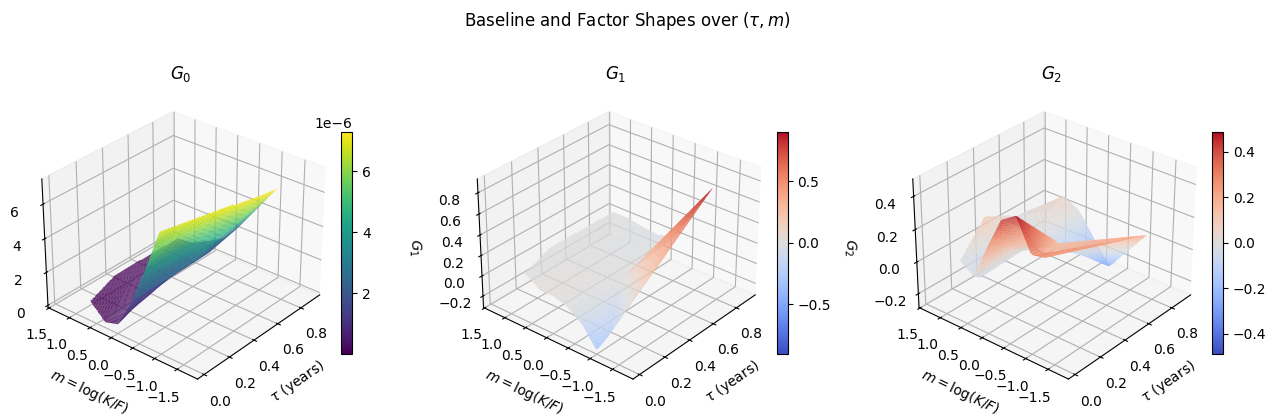

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.colors import TwoSlopeNorm
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D  # noqa

def _rectgrid_inside_triangulation(nodes, z, nx=100, ny=140, method='linear'):
    """Interpolate to a rectangular grid and mask points outside the (τ,m) triangulation."""
    τ = nodes[:,0].astype(float); m = nodes[:,1].astype(float)
    τg = np.linspace(τ.min(), τ.max(), nx)
    mg = np.linspace(m.min(), m.max(), ny)
    T, M = np.meshgrid(τg, mg)

    # which grid points are inside the triangulation?
    tri = mtri.Triangulation(τ, m)
    trifinder = tri.get_trifinder()
    tri_ix = trifinder(T, M)              # -1 outside, >=0 inside
    inside = tri_ix != -1

    Z = griddata((τ, m), np.asarray(z, float), (T, M), method=method)
    # mask outside (and any interpolation nans)
    Zm = np.ma.array(Z, mask=~inside | ~np.isfinite(Z))
    return T, M, Zm

def fig9_3d_rectgrid_masked(nodes, G0, G1, G2,
                            normalize_factors=True, with_contours=True,
                            nx=100, ny=140, elev=30, azim=-140):
    g0 = np.asarray(G0, float)
    g1 = np.asarray(G1, float)
    g2 = np.asarray(G2, float)
    if normalize_factors:
        for g in (g1, g2):
            n = np.linalg.norm(g); 
            if n > 0: g /= n

    T, M, Z0 = _rectgrid_inside_triangulation(nodes, g0, nx, ny, method='linear')
    _, _, Z1 = _rectgrid_inside_triangulation(nodes, g1, nx, ny, method='linear')
    _, _, Z2 = _rectgrid_inside_triangulation(nodes, g2, nx, ny, method='linear')

    fig = plt.figure(figsize=(16, 4.8))
    gs  = fig.add_gridspec(1, 3, wspace=0.18)

    def add(ax, Z, title, center0=False, cmap_main=None, cmap_cont=None):
        if center0:
            vabs = np.nanmax(np.abs(Z.data)) if hasattr(Z, "data") else np.nanmax(np.abs(Z))
            norm = TwoSlopeNorm(vmin=-vabs, vcenter=0.0, vmax=vabs)
            surf = ax.plot_surface(T, M, Z, rstride=1, cstride=1, linewidth=0,
                                   antialiased=True, cmap=cmap_main or 'coolwarm', norm=norm)
            if with_contours:
                ax.contour(T, M, Z, levels=12, zdir='z',
                           offset=np.nanmin(Z), cmap=cmap_cont or 'coolwarm')
        else:
            surf = ax.plot_surface(T, M, Z, rstride=1, cstride=1, linewidth=0,
                                   antialiased=True, cmap=cmap_main or 'viridis')
            if with_contours:
                ax.contour(T, M, Z, levels=12, zdir='z',
                           offset=np.nanmin(Z), cmap=cmap_cont or 'viridis')

        ax.view_init(elev=elev, azim=azim)
        ax.set_xlabel(r'$\tau$ (years)', labelpad=6)
        ax.set_ylabel(r'$m=\log(K/F)$', labelpad=6)
        ax.set_zlabel(title, labelpad=6)
        ax.set_title(title, pad=8)
        plt.colorbar(surf, ax=ax, shrink=0.6, pad=0.02)

    ax0 = fig.add_subplot(gs[0,0], projection='3d')
    add(ax0, Z0, r'$G_0$', center0=False, cmap_main='viridis', cmap_cont='viridis')

    ax1 = fig.add_subplot(gs[0,1], projection='3d')
    add(ax1, Z1, r'$G_1$', center0=True, cmap_main='coolwarm', cmap_cont='coolwarm')

    ax2 = fig.add_subplot(gs[0,2], projection='3d')
    add(ax2, Z2, r'$G_2$', center0=True, cmap_main='coolwarm', cmap_cont='coolwarm')

    fig.suptitle(r'Baseline and Factor Shapes over $(\tau,m)$', y=0.98)
    plt.tight_layout()
    return fig

# ---- usage ----
fig = fig9_3d_rectgrid_masked(nodes_sub, G0_price, G_dyn[0], G_dyn[1],
                               normalize_factors=True, with_contours=False)
plt.show()

fig = fig9_3d_rectgrid_masked(nodes_sub, G0_price, G_sa[0], G_dyn[1],
                               normalize_factors=True, with_contours=False)
plt.show()
